In [1]:
!pip install nltk

In [2]:
import requests
import pandas as pd
import numpy as np
import os
import io
from PIL import Image
from tqdm import tqdm

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

# Pytorch / Torchvision para modelos pre-entrenados
import torch
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns

# Tensor
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

#stopwords
import nltk
nltk.download('stopwords')  # Descarga las stopwords

from nltk.corpus import stopwords
spanish_stopwords = stopwords.words('spanish')

import re
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# IDENTIFICACIÓN DE LAS CATEGORIAS DE PRODUCTOS EXISTENTES
response = requests.get("https://api.mercadolibre.com/sites/MLA/categories")
categorias = response.json()
categorias

[{'id': 'MLA5725', 'name': 'Accesorios para Vehículos'},
 {'id': 'MLA1512', 'name': 'Agro'},
 {'id': 'MLA1403', 'name': 'Alimentos y Bebidas'},
 {'id': 'MLA1071', 'name': 'Animales y Mascotas'},
 {'id': 'MLA1367', 'name': 'Antigüedades y Colecciones'},
 {'id': 'MLA1368', 'name': 'Arte, Librería y Mercería'},
 {'id': 'MLA1743', 'name': 'Autos, Motos y Otros'},
 {'id': 'MLA1384', 'name': 'Bebés'},
 {'id': 'MLA1246', 'name': 'Belleza y Cuidado Personal'},
 {'id': 'MLA1039', 'name': 'Cámaras y Accesorios'},
 {'id': 'MLA1051', 'name': 'Celulares y Teléfonos'},
 {'id': 'MLA1648', 'name': 'Computación'},
 {'id': 'MLA1144', 'name': 'Consolas y Videojuegos'},
 {'id': 'MLA1500', 'name': 'Construcción'},
 {'id': 'MLA1276', 'name': 'Deportes y Fitness'},
 {'id': 'MLA5726', 'name': 'Electrodomésticos y Aires Ac.'},
 {'id': 'MLA1000', 'name': 'Electrónica, Audio y Video'},
 {'id': 'MLA2547', 'name': 'Entradas para Eventos'},
 {'id': 'MLA407134', 'name': 'Herramientas'},
 {'id': 'MLA1574', 'name': 'H

In [4]:
# Se crea una función para poder descargar información de cualquier categoria de las 32 mencionadas anteriormente
def get_items_meli(category_id='MLA1000', max_items=1000, step=50):
    """
    Descarga ítems de la API de Mercado Libre para una categoría dada.
    """
    all_rows = []
    offsets = range(0, max_items, step)

    for offset in offsets:
        url = f'https://api.mercadolibre.com/sites/MLA/search?category={category_id}&offset={offset}'
        response = requests.get(url).json()

        results = response.get('results', [])

        for item in results:
            shipping_info = item.get('shipping', {})

            row = {
                'item_id': item.get('id'),
                'title': item.get('title'),
                'category_id': item.get('category_id'),
                'domain_id': item.get('domain_id'),
                'price': item.get('price'),
                'currency_id': item.get('currency_id'),
                'available_quantity': item.get('available_quantity'),
                'sold_quantity': item.get('sold_quantity'),
                'listing_type_id': item.get('listing_type_id'),
                'condition': item.get('condition'),
                # shipping
                'shipping_free': shipping_info.get('free_shipping'),
                'shipping_logistic_type': shipping_info.get('logistic_type'),
                # Permalink al producto
                'permalink': item.get('permalink'),
                'imagen_url': item.get('thumbnail'),
                "brand": item.get('brands'),
                "model": item.get('models'),
                "color": item.get('colors'),
                "rating": item.get('ratings'),
                "reviews_count": item.get('reviews_count'),
                "publish_date": item.get('random_dates'),
                "discount": item.get('discounts'),
                "original_price": item.get('original_prices'),
                "final_price": item.get('final_prices'),
                "seller_id": item.get('seller_ids'),
                "seller_level": item.get('seller_levels')
            }
            all_rows.append(row)

    df = pd.DataFrame(all_rows)
    df.drop_duplicates(subset=['item_id'], inplace=True)

    return df


# **Significado características**

**brand y model:** Atributos típicos de productos (ej., si es un celular Samsung Galaxy A32, brand = "Samsung", model = "Galaxy A32").

**color:** Para artículos como celulares, televisores, etc., la variación de color puede ser relevante.

**rating y reviews_count:** Para medir la satisfacción de clientes o popularidad (ej. calificaciones y número de reseñas).

**discount:** Porcentaje de descuento (0% si no aplica).

**original_price:** Precio sin descuento (o precio de lista), para poder calcular el precio final real.

**publish_date:** Fecha en que se publicó el ítem, útil para series de tiempo.
seller_id y seller_level: Identificar el vendedor y su nivel o reputación.

In [5]:
# Construcción de un Data Frame ejeuctando la función anterior
varias_categorias = ['MLA1000', 'MLA1039']
df_items = get_items_meli('MLA1000', max_items=1000, step=50)
print("Número de ítems descargados:", len(df_items))
df_items

Número de ítems descargados: 994


,item_id,title,category_id,domain_id,price,currency_id,available_quantity,sold_quantity,listing_type_id,condition,...,model,color,rating,reviews_count,publish_date,discount,original_price,final_price,seller_id,seller_level
0,MLA1773617260,20 Pilas Aaa Energizer Max E92 Alcalina,MLA6384,MLA-CELL_BATTERIES,12815.50,ARS,500,None,gold_special,new,...,None,None,None,None,None,None,None,None,None,None
1,MLA1773629054,20 Pilas Aa Energizer Max E91 Alcalina,MLA6384,MLA-CELL_BATTERIES,12942.04,ARS,500,None,gold_special,new,...,None,None,None,None,None,None,None,None,None,None
2,MLA1427051009,Pila Aaa Energizer Max E92 Alcalina - Blister ...,MLA6384,MLA-CELL_BATTERIES,7087.00,ARS,200,None,gold_special,new,...,None,None,None,None,None,None,None,None,None,None
3,MLA1281087020,Auriculares Inalámbricos Lenovo Livepod Lp75 B...,MLA3697,MLA-HEADPHONES,30293.19,ARS,500,None,gold_special,new,...,None,None,None,None,None,None,None,None,None,None
4,MLA1987374428,Smart Tv Quint 43 Pulgadas Qt3-43gtv2024 Full ...,MLA1002,MLA-TELEVISIONS,358679.00,ARS,1,None,gold_special,new,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,MLA1143768224,Auricular Inalámbrico Orejas De Gato Bluetooth...,MLA3697,MLA-HEADPHONES,9375.00,ARS,500,None,gold_special,new,...,None,None,None,None,None,None,None,None,None,None
991,MLA1461215227,Pilas Audifono 13 Rayovac Extra Pr48 Pack X 40...,MLA6384,MLA-CELL_BATTERIES,25200.00,ARS,1,None,gold_special,new,...,None,None,None,None,None,None,None,None,None,None
992,MLA1390416281,Auriculares Inalámbricos Thonet And Vander Aur...,MLA3697,MLA-HEADPHONES,84114.80,ARS,500,None,gold_pro,new,...,None,None,None,None,None,None,None,None,None,None
993,MLA1457904133,Pilas Aa Recargable Blister X4 De 3300mah Dele...,MLA6384,MLA-CELL_BATTERIES,8328.00,ARS,1,None,gold_special,new,...,None,None,None,None,None,None,None,None,None,None


# **EDA**

In [6]:
# Verificación de valores nulos y tipos de datos
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 994
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   item_id                 994 non-null    object 
 1   title                   994 non-null    object 
 2   category_id             994 non-null    object 
 3   domain_id               994 non-null    object 
 4   price                   994 non-null    float64
 5   currency_id             994 non-null    object 
 6   available_quantity      994 non-null    int64  
 7   sold_quantity           0 non-null      object 
 8   listing_type_id         994 non-null    object 
 9   condition               994 non-null    object 
 10  shipping_free           994 non-null    bool   
 11  shipping_logistic_type  994 non-null    object 
 12  permalink               994 non-null    object 
 13  imagen_url              994 non-null    object 
 14  brand                   0 non-null      object 

In [7]:
# Verificación de valores nulos
df_items.isnull().sum()

,0
item_id,0
title,0
category_id,0
domain_id,0
price,0
currency_id,0
available_quantity,0
sold_quantity,994
listing_type_id,0
condition,0


In [8]:
# Estadísticos
df_items[["price", "available_quantity", "sold_quantity"]].describe()

,price,available_quantity
count,9.940000e+02,994.00000
mean,1.846959e+05,109.22837
std,3.883017e+05,405.81290
min,1.420000e+03,1.00000
25%,1.451134e+04,1.00000
50%,4.043900e+04,1.00000
75%,1.261468e+05,100.00000
max,4.029599e+06,5000.00000


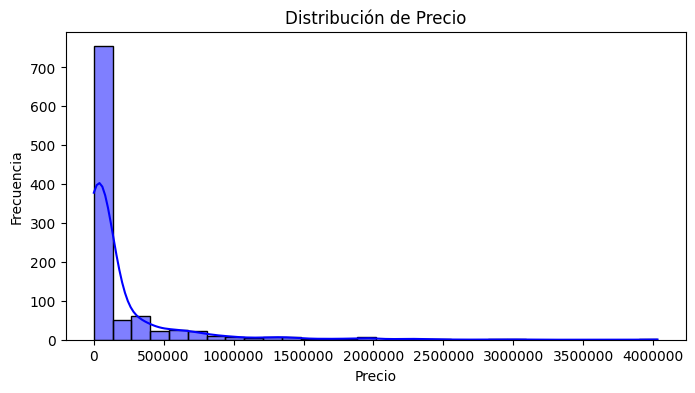

In [9]:
# Distribución del precio
plt.figure(figsize=(8, 4))
sns.histplot(df_items['price'], bins=30, kde=True, color='blue')
plt.ticklabel_format(axis='x', style='plain', useOffset=False)
plt.title("Distribución de Precio")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

In [10]:
# Obtenemos los conteos para cada categoría
vc = df_items['domain_id'].value_counts()

# Número total de categorías únicas
unique_cats = df_items['domain_id'].nunique()

print("Número de categorías únicas en domain_id:", unique_cats)

# Extraemos las 10 primeras
top10 = vc.head(10)

# Convertimos a DataFrame para facilidad de manipulación
df_top10 = top10.to_frame().reset_index()
df_top10.columns = ['domain_id', 'count']

# Agregamos columna de porcentaje respecto al total de filas de df_items
df_top10['pct'] = df_top10['count'] / len(df_items) * 100

df_top10

Número de categorías únicas en domain_id: 61


,domain_id,count,pct
0,MLA-HEADPHONES,345,34.708249
1,MLA-TELEVISIONS,166,16.700201
2,MLA-SPEAKERS,68,6.841046
3,MLA-CELL_BATTERIES,60,6.036217
4,MLA-MICROPHONES,55,5.533199
5,MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,32,3.219316
6,MLA-STREAMING_MEDIA_DEVICES,28,2.816901
7,MLA-TV_AND_MONITOR_STANDS_AND_WALL_HANGERS,26,2.615694
8,MLA-AM_FM_SW_RADIOS,23,2.313883
9,MLA-LED_STAGE_LIGHTS,16,1.609658


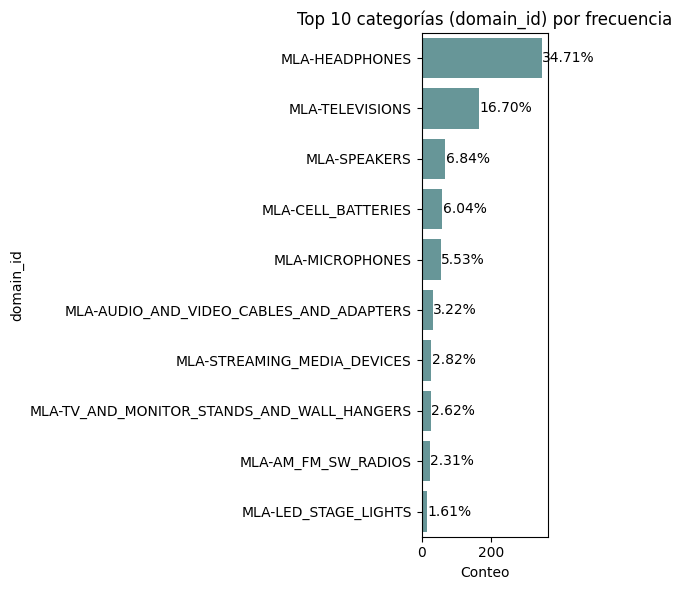

In [11]:
# Realizo gráfica mostrando las categorias más representativas de la información descargada
plt.figure(figsize=(6, 6))

sns.barplot(
    data=df_top10,
    y='domain_id',   # Eje Y (categoría)
    x='count',       # Eje X (conteo)
    orient='h',      # Barras horizontales
    color='cadetblue'
)

plt.title("Top 10 categorías (domain_id) por frecuencia")
plt.xlabel("Conteo")
plt.ylabel("domain_id")

# Para agregar las etiquetas de porcentaje al lado de cada barra:
for i, row in df_top10.iterrows():
    plt.text(
        row['count'] + 1.5,  # x-position (un poquito a la derecha de la barra)
        i,                   # y-position (el índice de la fila)
        f"{row['pct']:.2f}%",# texto a mostrar (porcentaje con 2 decimales)
        va='center'          # vertical alignment
    )

plt.tight_layout()
plt.show()

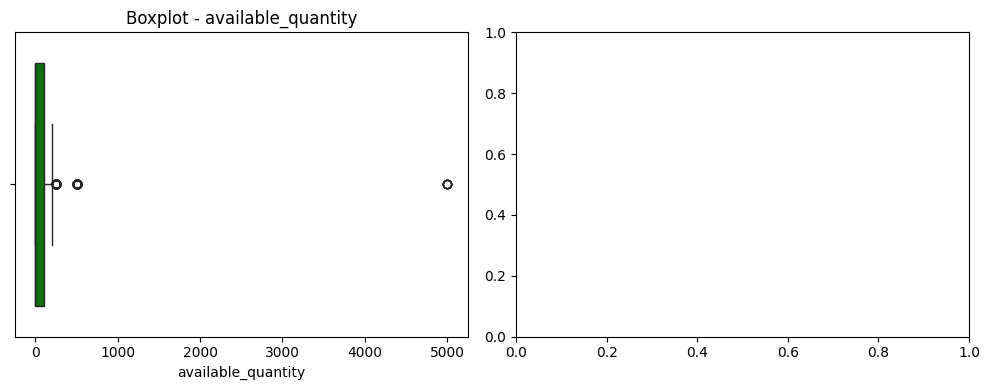

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=df_items, x='available_quantity', ax=ax[0], color='green')
ax[0].set_title("Boxplot - available_quantity")

plt.tight_layout()
plt.show()

In [13]:
df_items.groupby('shipping_free')['price'].mean()

,price
shipping_free,
False,96398.067122
True,244905.798765


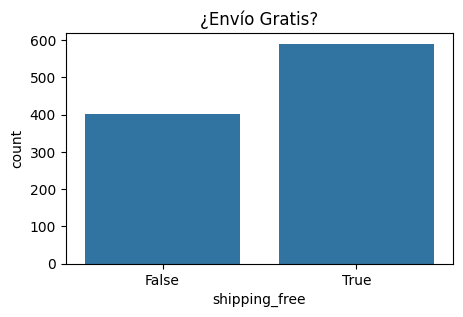

In [14]:
plt.figure(figsize=(5, 3))
sns.countplot(x='shipping_free', data=df_items)
plt.title("¿Envío Gratis?")
plt.show()

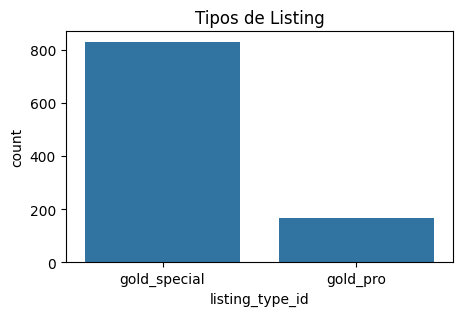

In [15]:
plt.figure(figsize=(5, 3))
sns.countplot(x='listing_type_id', data=df_items)
plt.title("Tipos de Listing")
plt.show()

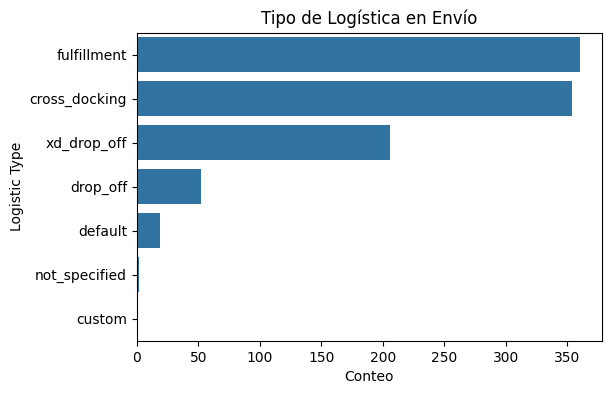

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(y='shipping_logistic_type', data=df_items,
              order=df_items['shipping_logistic_type'].value_counts().index)
plt.title("Tipo de Logística en Envío")
plt.xlabel("Conteo")
plt.ylabel("Logistic Type")
plt.show()

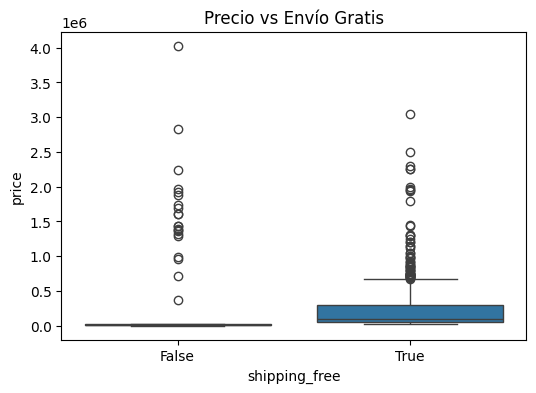

In [17]:
plt.figure(figsize=(6,4))
sns.boxplot(x='shipping_free', y='price', data=df_items)
plt.title("Precio vs Envío Gratis")
plt.show()

In [18]:
pd.crosstab(df_items['shipping_logistic_type'], df_items['condition'])

condition,new
shipping_logistic_type,
cross_docking,354
custom,1
default,19
drop_off,52
fulfillment,360
not_specified,2
xd_drop_off,206


Este campo ayuda a entender el tipo de servicio de envío y qué actor (vendedor, Mercado Libre o un socio logístico) interviene en la manipulación del paquete.

**shipping_free (booleano):**

Indica si el artículo cuenta con envío gratis o no.
True significa que el comprador no debe pagar un costo adicional de envío (por ejemplo, si está subsidiado por Mercado Libre o el seller).

**shipping_logistic_type (string):**

Describe cómo se gestionan los envíos logísticamente. Entre los valores más comunes:

**cross_docking:** se refiere a una modalidad en la que Mercado Libre (o un tercero) maneja el producto en sus bodegas y lo despacha.

**drop_off:** el vendedor lleva el producto a un punto de despacho.

**xd_drop_off:** una combinación más específica de logística.

**fulfillment:** Mercado Libre se encarga completamente de la logística.



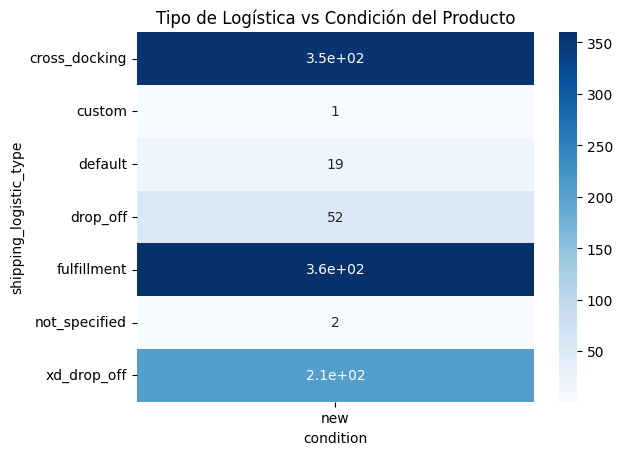

In [19]:
cross_tab = pd.crosstab(df_items['shipping_logistic_type'], df_items['condition'])
sns.heatmap(cross_tab, annot=True, cmap='Blues')
plt.title("Tipo de Logística vs Condición del Producto")
plt.show()

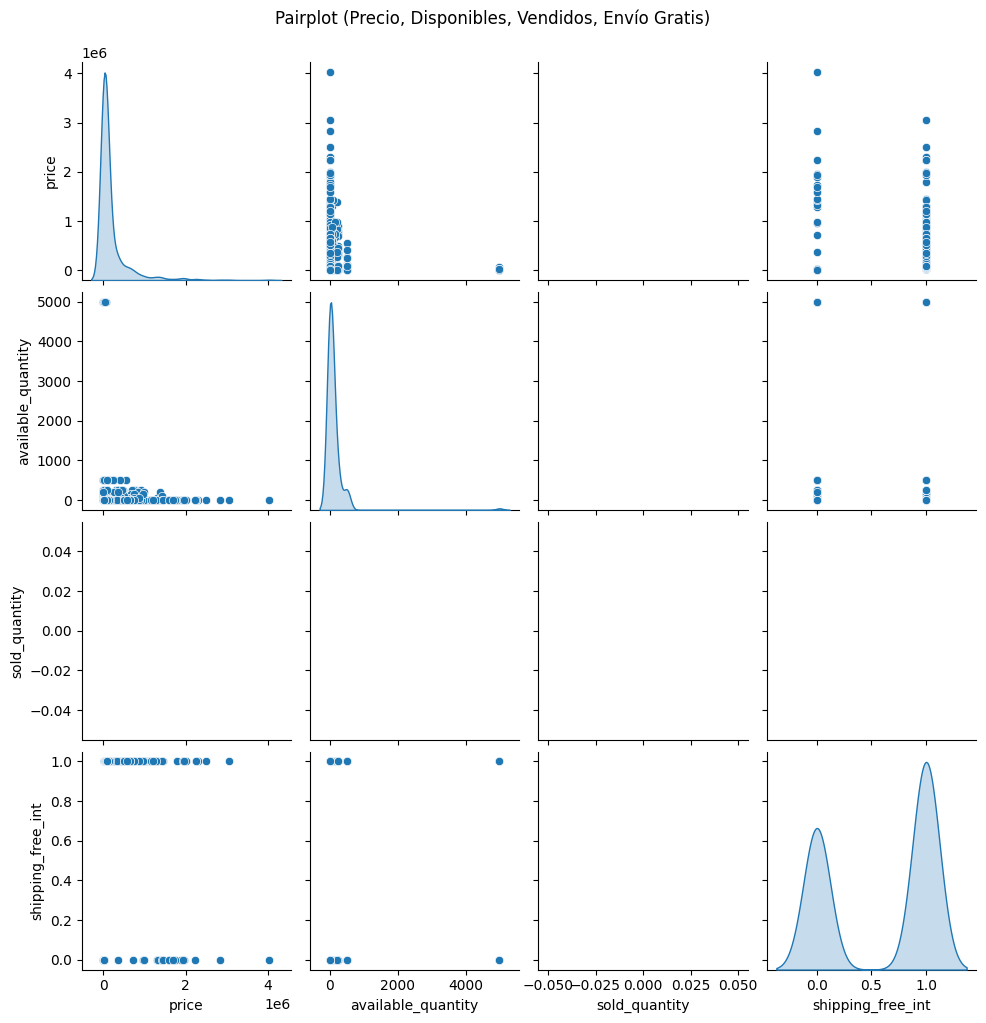

In [20]:
df_items['shipping_free_int'] = df_items['shipping_free'].astype(int)

sns.pairplot(df_items[['price','available_quantity','sold_quantity','shipping_free_int']], diag_kind='kde')
plt.suptitle("Pairplot (Precio, Disponibles, Vendidos, Envío Gratis)", y=1.02)
plt.show()

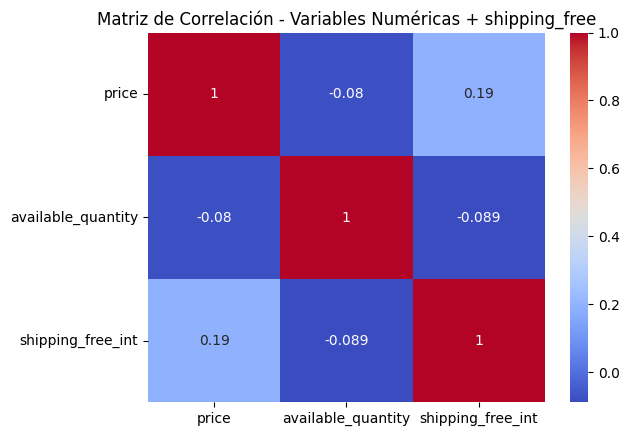

In [21]:
df_items['shipping_free_int'] = df_items['shipping_free'].astype(int)
corr = df_items[['price','available_quantity','shipping_free_int']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación - Variables Numéricas + shipping_free")
plt.show()

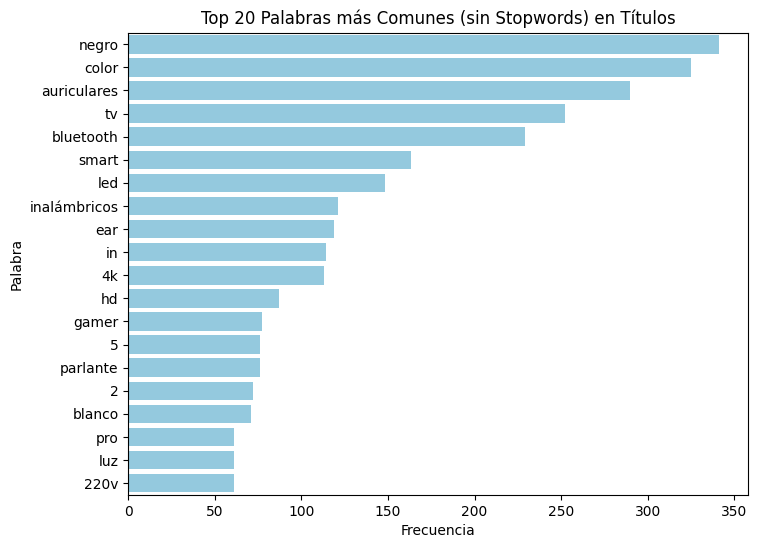

In [22]:
# Palabras más frecuentes en títulos para poder analizar

# 1. Obtener las 20 palabras más comunes
all_titles = " ".join(df_items['title'].astype(str)).lower()
all_words = re.findall(r'\w+', all_titles)
# Filtramos stopwords
filtered_words = [word for word in all_words if word not in spanish_stopwords]

counter = Counter(filtered_words)
most_common_words = counter.most_common(20)  # top 20

# 2. Convertimos a DataFrame
df_words = pd.DataFrame(most_common_words, columns=['word','count'])

# 3. Gráfico de Barras Horizontal
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_words,
    x='count',
    y='word',
    orient='h',
    color='skyblue'
)
plt.title("Top 20 Palabras más Comunes (sin Stopwords) en Títulos")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

## **MODELACION**

luego de definido el objetivo, procedemos a modelar los títulos y las imágenes para poder mejorar la experiencia de los clientes cuando ingresan al Marketplace

**Cáldulo embeddings para titulos**

In [23]:
# 1) Selecciona las columnas necesarias
df_text = df_items[['item_id', 'title']].copy()

# 2) Elimina filas que tengan 'title' nulo o vacío
df_text.dropna(subset=['title'], inplace=True)

# eliminar también títulos vacíos o muy cortos
df_text = df_text[df_text['title'].str.strip() != '']

# 3) Elimina duplicados de 'item_id' si corresponde
df_text.drop_duplicates(subset=['item_id'], inplace=True)

df_text.reset_index(drop=True, inplace=True)

In [24]:
vectorizer = TfidfVectorizer(stop_words=spanish_stopwords, lowercase=True)
tfidf_matrix = vectorizer.fit_transform(df_text['title'])

print("Shape de TF-IDF:", tfidf_matrix.shape)

Shape de TF-IDF: (994, 1981)


In [25]:
# Convertimos la matriz sparse a dense para que sea más fácil almacenarla
X_tfidf_dense = tfidf_matrix.toarray()  # shape [N, D]

# Agregamos la columna con embeddings al df_text
df_items['text_embedding'] = list(X_tfidf_dense)

In [26]:
# Cálculo de matriz de similaridad de texto
text_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

# para el ítem 0, mostrar los 5 ítems más similares en texto
idx = 0
similarities = text_similarity[idx]
top5_idx = np.argsort(-similarities)[1:6]  # los 5 más parecidos (excluimos el 0, que es el item en sí mismo)

print("TÍTULO BASE:\n", df_items.iloc[idx]['title'], "\n")
for i in top5_idx:
    print(f"Similaridad={similarities[i]:.2f} | {df_items.iloc[i]['title']}")

TÍTULO BASE:
 20 Pilas Aaa Energizer Max E92 Alcalina 

Similaridad=0.88 | 4 Pilas Aaa Energizer Max E92 Alcalina
Similaridad=0.67 | 20 Pilas Aa Energizer Max E91 Alcalina
Similaridad=0.63 | Pila Aaa Energizer Max E92 Alcalina - Blister De 10 Unidades
Similaridad=0.62 | Pila Aaa Energizer Max E92 Alcalina Pack De 40 Unidades
Similaridad=0.54 | Pila Aaa Energizer Max E92 Cilíndrica - Pack De 6 Unidades


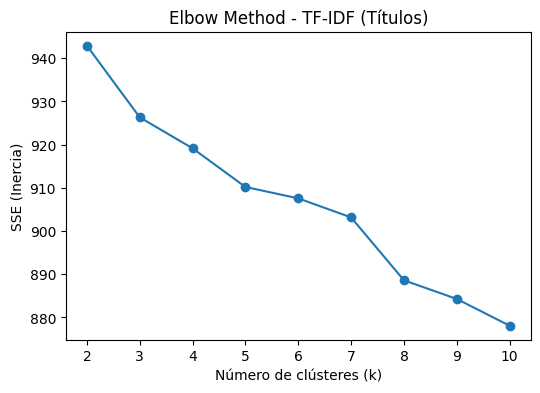

In [27]:
# Función paraa calcular cuantos segmentos podemos escoger según metodología Elbow
def elbow_method(X, k_min=2, k_max=10):
    sse = []
    K_range = range(k_min, k_max+1)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    return sse

sse_text = elbow_method(tfidf_matrix, k_min=2, k_max=10)

K_range = range(2, 11)
plt.figure(figsize=(6,4))
plt.plot(K_range, sse_text, marker='o')
plt.title("Elbow Method - TF-IDF (Títulos)")
plt.xlabel("Número de clústeres (k)")
plt.ylabel("SSE (Inercia)")
plt.show()

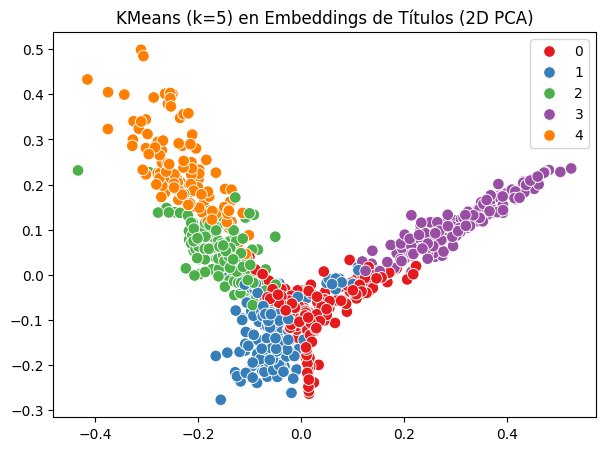

In [28]:
k_text = 5
kmeans_text = KMeans(n_clusters=k_text, random_state=42)
labels_text = kmeans_text.fit_predict(tfidf_matrix)

pca = PCA(n_components=2, random_state=42)
tfidf_2d = pca.fit_transform(tfidf_matrix.toarray())  # tfidf_matrix -> dense

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=tfidf_2d[:,0],
    y=tfidf_2d[:,1],
    hue=labels_text,
    palette='Set1',
    s=70
)
plt.title(f"KMeans (k={k_text}) en Embeddings de Títulos (2D PCA)")
plt.show()

In [29]:
# Asignación de segmento
NUM_CLUSTERS = 5
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
kmeans.fit(tfidf_matrix)

df_items['text_cluster'] = kmeans.labels_
df_items.groupby('text_cluster')['title'].count()

,title
text_cluster,
0,333
1,194
2,169
3,182
4,116


**Cálculo embeddings para imágenes**

In [30]:
model_resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def get_image_embedding(img_url):
    try:
        resp = requests.get(img_url, timeout=5)
        img_data = resp.content
        pil_img = Image.open(io.BytesIO(img_data)).convert('RGB')

        # redimensionar a 224x224
        pil_img = pil_img.resize((224, 224))
        x = image.img_to_array(pil_img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        embedding = model_resnet.predict(x)
        return embedding[0]  # shape (2048,)
    except:
        return None

# Extraer embeddings
embeddings_img = []
for url in df_items['imagen_url']:
    emb = get_image_embedding(url)
    embeddings_img.append(emb)

df_items['img_embedding'] = embeddings_img
df_items = df_items.dropna(subset=['img_embedding']).reset_index(drop=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━

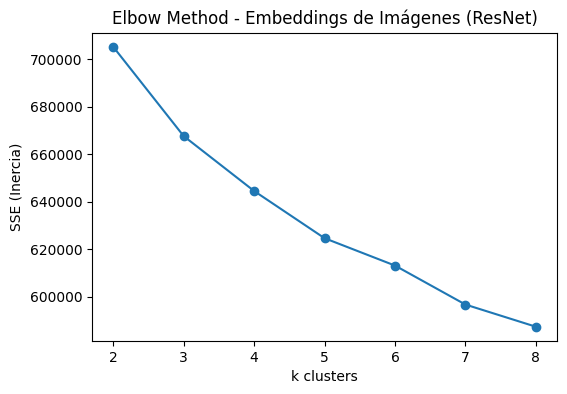

In [31]:
# Convertir embeddings_img a un array 2D
X_img = np.vstack(df_items['img_embedding'].values)

sse_img = elbow_method(X_img, k_min=2, k_max=8)

K_range_img = range(2,9)
plt.figure(figsize=(6,4))
plt.plot(K_range_img, sse_img, marker='o')
plt.title("Elbow Method - Embeddings de Imágenes (ResNet)")
plt.xlabel("k clusters")
plt.ylabel("SSE (Inercia)")
plt.show()

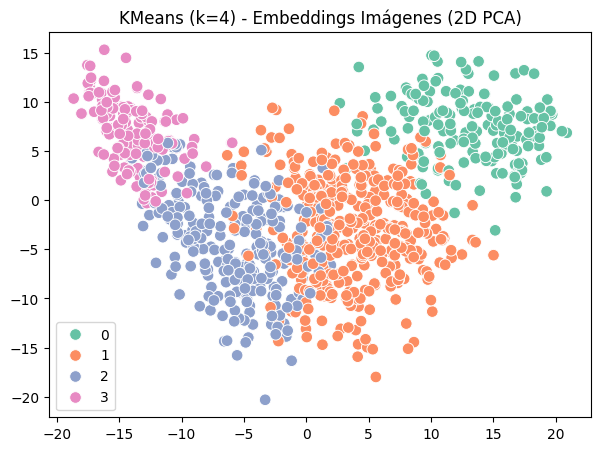

In [32]:
k_img = 4  # ejemplo
kmeans_img = KMeans(n_clusters=k_img, random_state=42)
labels_img = kmeans_img.fit_predict(X_img)

# Visualización con PCA:
pca_img = PCA(n_components=2, random_state=42)
X_img_2d = pca_img.fit_transform(X_img)

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=X_img_2d[:,0],
    y=X_img_2d[:,1],
    hue=labels_img,
    palette='Set2',
    s=70
)
plt.title(f"KMeans (k={k_img}) - Embeddings Imágenes (2D PCA)")
plt.show()

In [38]:
# Convertimos tfidf_matrix (sparse) a dense, y X_img ya es dense
X_text = tfidf_matrix.toarray()
X_img = np.vstack(df_items['img_embedding'].values)

common_item_ids = df_items['item_id'].isin(df_text['item_id']).values

X_text = X_text[df_text['item_id'].isin(df_items['item_id'])]

X_img = X_img[common_item_ids]

X_combined = np.hstack([X_text, X_img])

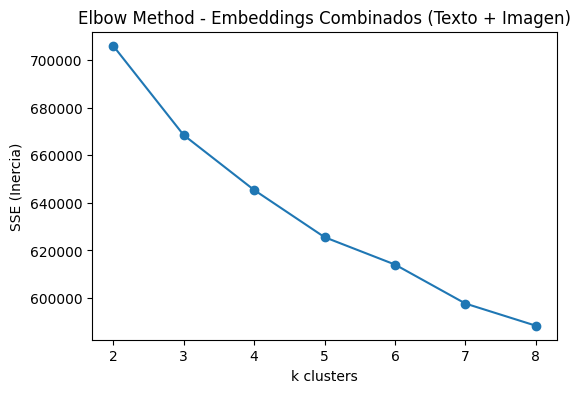

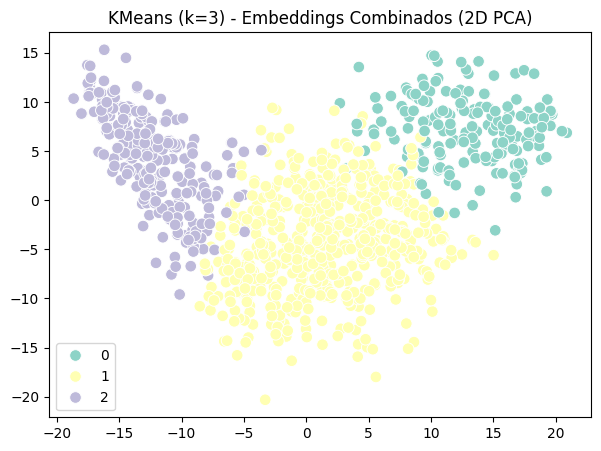

In [39]:
sse_comb = elbow_method(X_combined, k_min=2, k_max=8)

plt.figure(figsize=(6,4))
plt.plot(range(2,9), sse_comb, marker='o')
plt.title("Elbow Method - Embeddings Combinados (Texto + Imagen)")
plt.xlabel("k clusters")
plt.ylabel("SSE (Inercia)")
plt.show()

k_comb = 3  # ejemplo
kmeans_comb = KMeans(n_clusters=k_comb, random_state=42)
labels_comb = kmeans_comb.fit_predict(X_combined)

# Visualizar con PCA
pca_comb = PCA(n_components=2, random_state=42)
X_comb_2d = pca_comb.fit_transform(X_combined)

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_comb_2d[:,0], y=X_comb_2d[:,1],
                hue=labels_comb,
                palette='Set3',
                s=70)
plt.title(f"KMeans (k={k_comb}) - Embeddings Combinados (2D PCA)")
plt.show()

In [40]:
# calculo de estadístico silueta para comparar la consistencia de los segmentos
score_text = silhouette_score(tfidf_matrix, labels_text)
score_img = silhouette_score(X_img, labels_img)
score_comb = silhouette_score(X_combined, labels_comb)

print(f"Silhouette SOLO TEXTO: {score_text:.3f}")
print(f"Silhouette SOLO IMAGEN: {score_img:.3f}")
print(f"Silhouette COMBINADO: {score_comb:.3f}")

Silhouette SOLO TEXTO: 0.024
Silhouette SOLO IMAGEN: 0.070
Silhouette COMBINADO: 0.076


In [41]:
# Función para calcular la distancia intracluster
def avg_intra_cluster_dist(X, labels):
    cluster_ids = np.unique(labels)
    dist_prom = {}
    for cid in cluster_ids:
        idx = np.where(labels == cid)[0]
        if len(idx) > 1:
            dist_matrix = pairwise_distances(X[idx], X[idx], metric='euclidean')
            # Tomamos parte triangular superior para no duplicar
            tri_upper = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
            dist_prom[cid] = np.mean(tri_upper)
        else:
            dist_prom[cid] = 0.0
    return dist_prom

dist_text = avg_intra_cluster_dist(tfidf_matrix, labels_text)
dist_img = avg_intra_cluster_dist(X_img, labels_img)
dist_comb = avg_intra_cluster_dist(X_combined, labels_comb)

print("Distancias intra-clúster (Texto):", dist_text)
print("Distancias intra-clúster (Imagen):", dist_img)
print("Distancias intra-clúster (Combinado):", dist_comb)

Distancias intra-clúster (Texto): {0: 1.4021868908824167, 1: 1.3706315352703573, 2: 1.3511692028455446, 3: 1.3011258616268846, 4: 1.274922275775872}
Distancias intra-clúster (Imagen): {0: 33.020058, 1: 37.828716, 2: 37.03649, 3: 29.463642}
Distancias intra-clúster (Combinado): {0: 33.53862856140322, 1: 37.79215828982316, 2: 34.52359506732428}
